# Exercise 5. Classification

The aim of this exercise is to train 4 different machine learning models for predicting the forest main tree species from satellite data.

It also assesses the model accuracy with a test dataset but also predicts the main tree species for the training image.

This exercise uses forest stands and Sentinel 2A satellite data prepared in Exercise 2.
If you have not done Exercies 2, just change the next cell to type Code from the toolbar above and run it to download the prepared data.

In [1]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
#Set working directory and input/output file names.
base_folder = "/home/jovyan/work/geocomputing/machineLearning/data/forest"

# Input
inputImage =  os.path.join(base_folder,'T34VFM_20180829T100019_clipped_small_scaled.tif')
labelsImage =  os.path.join(base_folder,'forest_species_reclassified_clip_small.tif')

# Output
outputImageBase= os.path.join(base_folder,'T34VFM_20180829T100019_clipped_')

In [3]:
base_folder = "./"
inputImage = 'toolo.tif'
labelsImage = 'classes.tif'
outputImageBase = 'toolo_'

In [4]:
# Available cores. In Notebooks only 1 core is available, on local PC or some other environment likely more cores are available, so increase this then.
n_jobs = 1

## 5.1 Read data and shape it to suitable form for scikit-learn.

Read the input datasets with Rasterio and shape it to suitable form for scikit-learn.

Exactly the same as for K-means for image data, the same only added for labels image.

### 5.1.1 Satellite image

We have to change the data format from bands x width x height to width*height x bands

This means that each pixel from the original dataset has own row in the result dataframe.

In [5]:
# Read the pixel values from .tif file as dataframe
image_dataset = rasterio.open(inputImage)  
image_data = image_dataset.read()

# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    
# First move the bands to last axis.

Dataframe original shape, 3D:  (3, 5624, 6084)


In [6]:
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (5624, 6084, 3)


In [7]:
# Then reshape to 1D.
pixels = image_data2.reshape(-1, 3)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (34216416, 3)


### 5.1.2 Forest classes image as labels

Do the same for labels.

In [8]:
# For labels only reshape to 1D is enough.
labels_dataset = rasterio.open(labelsImage)
labels_data = labels_dataset.read()
input_labels = labels_data.reshape(-1)
print ('Labels shape after reshape, 1D: ', input_labels.shape)

Labels shape after reshape, 1D:  (34216416,)


### 5.1.3 Sampling

The forest classes are very imbalanced in the dataset, so undersample the majority classes 

In [9]:
rus = RandomUnderSampler(random_state=63)
pixels_resampled, labels_resampled = rus.fit_resample(pixels, input_labels)   
print ('Dataframe shape after undersampling of majority classes, 2D: ', pixels_resampled.shape)

Dataframe shape after undersampling of majority classes, 2D:  (14608, 3)


### 5.1.4 Divide the data to test and training datasets

In [10]:
x_train, x_test, y_train, y_test = train_test_split(pixels_resampled, labels_resampled, test_size=0.2, random_state=63)
np.unique(y_train, return_counts=True)

#Clean up, to save space in memory
del image_data, image_data2, pixels, labels_data, input_labels

## 5.2 Funcitons for training and estimating the models and predicting based on the models

Fit and predict 4 models on the data. Each outputs a .tif image with the predicted classification.
The workflow is the same for all, except for SVM smaller sample of data is used.

Similar functions will be used by different algorithms. Here the functions are only defined, they will be used later.

### 5.2.1 Training the model

In [11]:
# Train the model and see how long it took.
def trainModel(x_train, y_train, clf, classifierName):
    start_time = time.time()    
    # training the model
    clf.fit(x_train, y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    
    # Save the model to a file
    modelFilePath = os.path.join(base_folder, ('model_' + classifierName + '.sav'))
    dump(clf, modelFilePath) 
    return clf

### 5.2.2 Estimating the model

In [12]:
# Predict on test data and see the model accuracy
def estimateModel(clf, x_test, y_test):
    test_predictions = clf.predict(x_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, test_predictions))
    print('Classification report: \n', classification_report(y_test, test_predictions))

### 5.2.3 Predict classification base on an image

In [13]:
# Predict on whole image and save it as .tif file
def predictImage(modelName, predictImage):
    #Set file paths for input and output files
    predictedClassesFile = outputImageBase + modelName + '.tif'
    predictedClassesPath = os.path.join(base_folder, predictedClassesFile)
    
    # Read the satellite image
    with rasterio.open(predictImage, 'r') as image_dataset:
        start_time = time.time()    
        
        #Reshape data to 1D as we did before model training
        image_data = image_dataset.read()
        image_data2 = np.transpose(image_data, (1, 2, 0))
        pixels = image_data2.reshape(-1, 3)
        
        #Load the model from the saved file
        modelFilePath = os.path.join(base_folder, ('model_' + modelName + '.sav'))
        trained_model = load(modelFilePath)
        
        # predict the class for each pixel
        prediction = trained_model.predict(pixels)
        
        # Reshape back to 2D
        print('Prediction shape in 1D: ', prediction.shape)
        prediction2D = np.reshape(prediction, (image_dataset.meta['height'], image_dataset.meta['width']))
        print('Prediction shape in 2D: ', prediction2D.shape)
        
        # Save the results as .tif file.
        # Copy the coorindate system information, image size and other metadata from the satellite image 
        outputMeta = image_dataset.meta
        # Change the number of bands and data type.
        outputMeta.update(count=1, dtype='uint8')
        # Writing the image on the disk
        with rasterio.open(predictedClassesPath, 'w', **outputMeta) as dst:
            dst.write(prediction2D, 1)
        print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')
 

## 5.3 Random forest     

In [14]:
classifierName = 'random_forest'
# Initialize the random forest classifier and give the hyperparameters.
clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=n_jobs)
clf_random_forest = trainModel(x_train, y_train, clf_random_forest, classifierName)
estimateModel(clf_random_forest, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_random_forest.feature_importances_)

Model training took:  0.49  seconds
Confusion matrix: 
 [[561  38  83  23]
 [ 31 664  23  22]
 [132  10 546   2]
 [204 171  79 333]]
Classification report: 
               precision    recall  f1-score   support

           1       0.60      0.80      0.69       705
           2       0.75      0.90      0.82       740
           3       0.75      0.79      0.77       690
         251       0.88      0.42      0.57       787

    accuracy                           0.72      2922
   macro avg       0.74      0.73      0.71      2922
weighted avg       0.75      0.72      0.71      2922



KeyboardInterrupt: 

## 5.4 Stochastic Gradient Decent

In [ ]:
classifierName = 'SGD'    
clf_SGD = SGDClassifier(loss="log", learning_rate='adaptive', alpha=1e-5,  eta0=.1, n_jobs=n_jobs, max_iter=200, penalty='l1')
clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName, inputImage)

## 5.5 Gradient Boost    

In [ ]:
classifierName = 'gradient_boost'    
clf_gradient_boost = GradientBoostingClassifier(n_estimators=50, learning_rate=.05)
clf_gradient_boost = trainModel(x_train, y_train, clf_gradient_boost, classifierName)
estimateModel(clf_gradient_boost, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_gradient_boost.feature_importances_)    

## 5.6 SVM Support Vector Classifier

SVM training becomes slow big amounts of training data, so use only small part of the data (20 %).

In [ ]:
# Take only 20% of data 
sp = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=63)
for train_index, _ in sp.split(pixels_resampled, labels_resampled):
    input_image2, input_labels2 = pixels_resampled[train_index], labels_resampled[train_index]
print ('Dataframe after downsampling for SVM, shape 2D: ', input_image2.shape) 

# Divide this smaller sample to test and training datasets
x_train2, x_test2, y_train2, y_test2 = train_test_split(input_image2, input_labels2, test_size=0.2, random_state=63)

In [17]:
classifierName = 'SVM'        
clf_svc = SVC(kernel='rbf', gamma='auto',  decision_function_shape='ovr')
clf_svc = trainModel(x_train2, y_train2, clf_svc, classifierName)
estimateModel(clf_svc, x_test2, y_test2)
# Predicting the image with SVM takes 2-3 min, so we skip it here. 
# predictImage(classifierName, inputImage) #SVM   

Model training took:  0.34  seconds
Confusion matrix: 
 [[133   2   1   8]
 [118  40   1   4]
 [ 80   2  63   2]
 [ 73   4   0  54]]
Classification report: 
               precision    recall  f1-score   support

           1       0.33      0.92      0.49       144
           2       0.83      0.25      0.38       163
           3       0.97      0.43      0.59       147
         251       0.79      0.41      0.54       131

    accuracy                           0.50       585
   macro avg       0.73      0.50      0.50       585
weighted avg       0.73      0.50      0.50       585



## 5.7 Grid Search for SVC

Different models have different settings that can be used for searching best model. Grid search gives option to automatically search for best option.

Here we try different `C` and `gamma` values for the SVM model. Grid search automatically saves the best model.

Notice, how the results are improved from the first SVM result above.

In [ ]:
classifierName = 'SVC_grid_search'        
# Find the optimal parameters for SVM
param_grid = {'C': [1000, 10000], 'gamma': [1, 10]}
# Initialize the grid search, cv is the number of iterations, kept at minimum here for faster results.
grid = GridSearchCV(SVC(), param_grid, verbose=1, n_jobs=n_jobs, cv=2)    
# Try different options
grid = trainModel(x_train2, y_train2, grid, classifierName)

# Plot the best option
print('Best selected parameters: ',format(grid.best_params_))
print('Best estimator: ',format(grid.best_estimator_))

# Test the classifier using test data
estimateModel(grid, x_test, y_test)

# Predict again on the small tile.
predictImage(classifierName, inputImage)  

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Model training took:  2.12  seconds
Best selected parameters:  {'C': 1000, 'gamma': 1}
Best estimator:  SVC(C=1000, gamma=1)
Confusion matrix: 
 [[688   1   5  11]
 [527 197   3  13]
 [348   2 329  11]
 [420   7   8 352]]
Classification report: 
               precision    recall  f1-score   support

           1       0.35      0.98      0.51       705
           2       0.95      0.27      0.42       740
           3       0.95      0.48      0.64       690
         251       0.91      0.45      0.60       787

    accuracy                           0.54      2922
   macro avg       0.79      0.54      0.54      2922
weighted avg       0.79      0.54      0.54      2922



## Plot the results

Create plots in similar way as in Exercise 2 and 4.

* Results of random forest
* Results of Stochastic Gradient Decent
* Results of gradient boost
* Results of SVM

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.plot import show_hist

In [16]:
### Help function to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'labels'}>

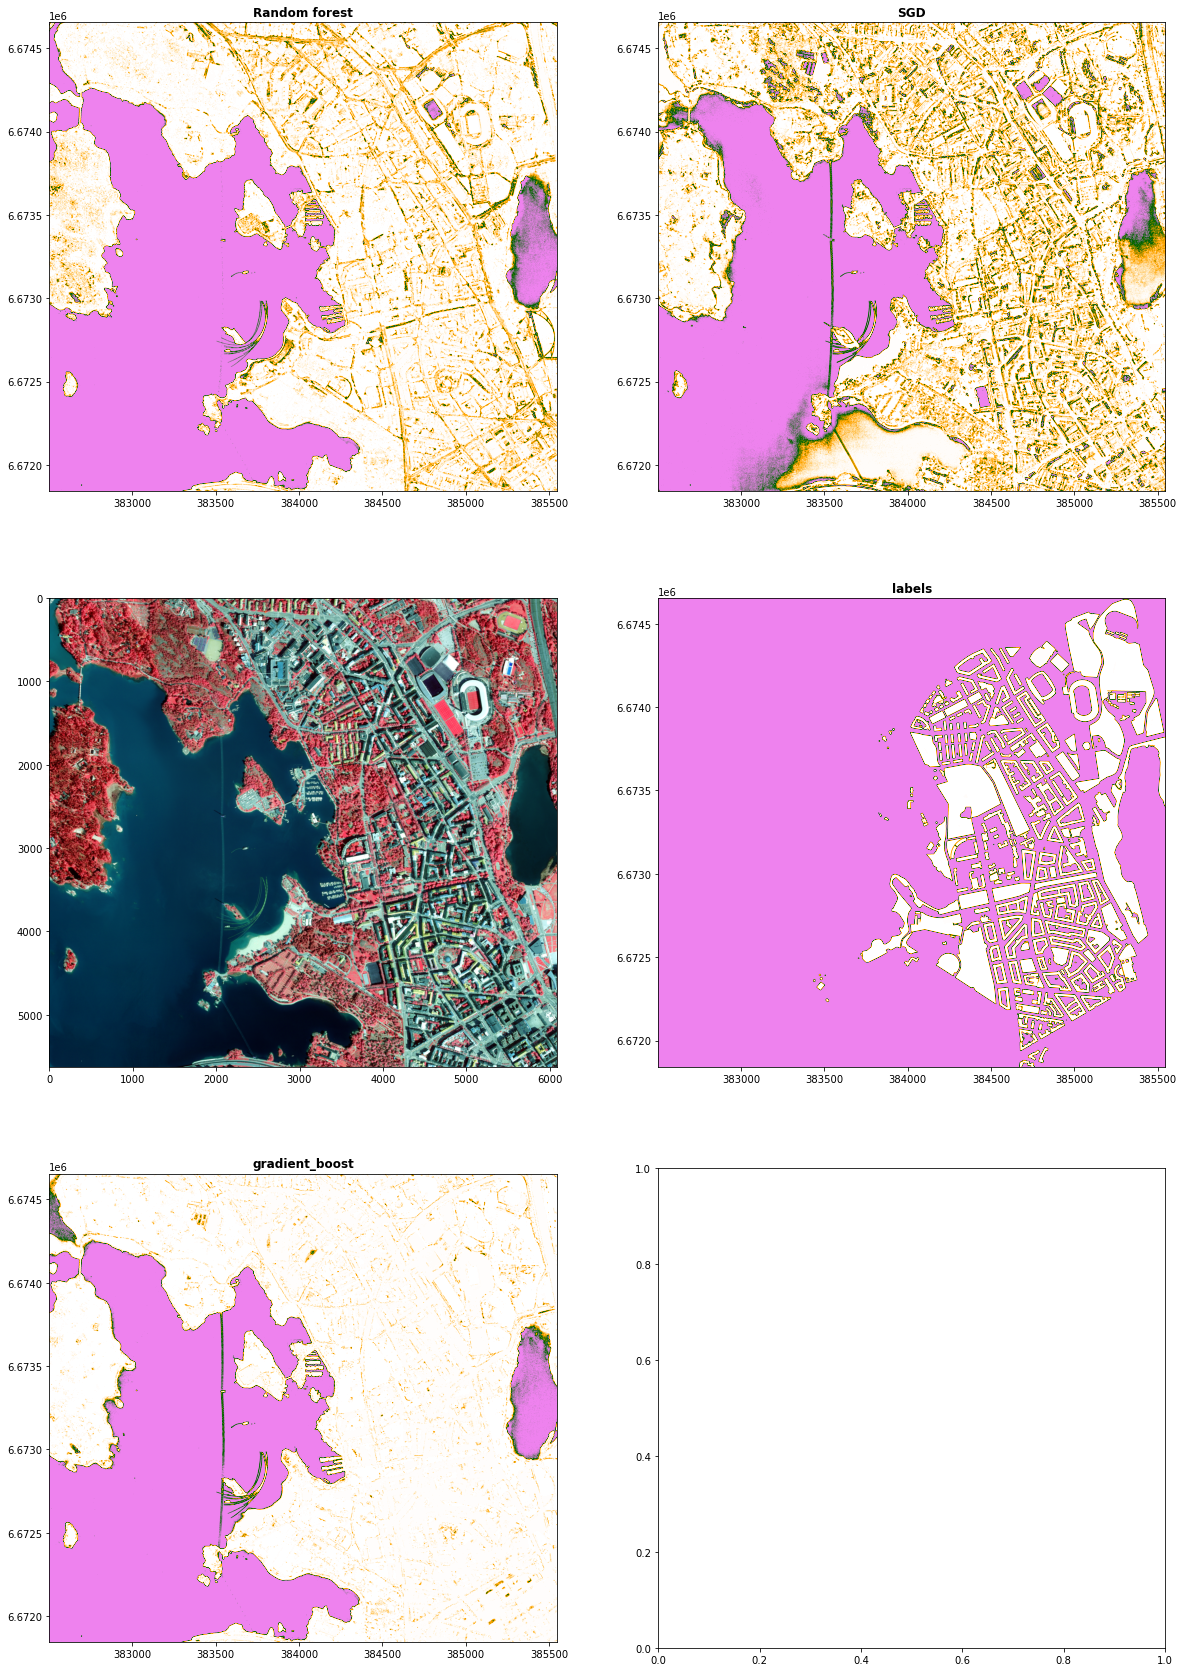

In [18]:
### Create a subplot for 4 images and plot the sentinel image 
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 30))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","darkgreen","violet"])

### The results
rf_results = rasterio.open(outputImageBase+'random_forest.tif')
show(rf_results, ax=ax[0, 0], cmap=cmap, title='Random forest')

SGD_results = rasterio.open(outputImageBase+'SGD.tif')
show(SGD_results, ax=ax[0, 1], cmap=cmap, title='SGD')

gradient_boost_results = rasterio.open(outputImageBase+'gradient_boost.tif')
show(gradient_boost_results, ax=ax[2, 0], cmap=cmap, title='gradient_boost')

#SVM_results = rasterio.open(outputImageBase+'SVM.tif')
#show(SVM_results, ax=ax[2, 0], cmap=cmap, title='SVM')

#SVM_grid_search_results = rasterio.open(outputImageBase+'SVC_grid_search.tif')
#show(SVM_grid_search_results, ax=ax[2, 1], cmap=cmap, title='SVM grid search')

### Plot the sentinel image 
### The Sentinel image used for training  
sentinel = rasterio.open(inputImage)

### Read the bands separately and apply the normalize function to each of them to increase contrast
nir, red, green = sentinel.read(1), sentinel.read(2), sentinel.read(3)
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.dstack((nirn, redn, greenn))

ax[1, 0].imshow(stacked)

labels = rasterio.open(labelsImage)
show(labels, ax=ax[1,1], cmap=cmap, title='labels')

In [27]:
import sys
for i in dir():
    print (i, sys.getsizeof(eval(i)) )

GradientBoostingClassifier 2008
GridSearchCV 1472
In 344
NOTEBOOK_HOME 107
Out 232
RandomForestClassifier 2008
RandomUnderSampler 1192
SGDClassifier 2008
SGD_results 240
SVC 2008
SVM_grid_search_results 240
StratifiedShuffleSplit 1064
_ 495152
_26 48
__ 49
___ 49
__builtin__ 72
__builtins__ 72
__doc__ 113
__loader__ 16
__name__ 57
__package__ 16
__spec__ 16
_dh 96
_exit_code 24
_i 1466
_i1 255
_i10 226
_i11 181
_i12 273
_i13 265
_i14 306
_i15 485
_i16 347
_i17 1763
_i18 506
_i19 346
_i2 601
_i20 425
_i21 565
_i22 379
_i23 738
_i24 226
_i25 351
_i26 1466
_i27 114
_i3 447
_i4 211
_i5 307
_i6 351
_i7 1466
_i8 262
_i9 307
_ih 344
_ii 351
_iii 226
_oh 232
ax 160
base_folder 107
classification_report 136
classifierName 64
clf_SGD 48
clf_gradient_boost 48
clf_random_forest 48
clf_svc 48
cmap 48
confusion_matrix 136
dump 136
estimateModel 136
exit 48
fig 48
get_ipython 64
gradient_boost_results 240
green 1690112
greenn 1690112
grid 48
image_dataset 240
inputImage 155
input_image2 185752
input_

In [28]:
import os
print (os.environ)

environ({'SHELL': '/bin/bash', 'KUBERNETES_SERVICE_PORT_HTTPS': '443', 'KUBERNETES_SERVICE_PORT': '443', 'GLUSTERFS_DYNAMIC_07809DFE_11FF_11EB_92D3_FA163E0D8841_PORT_1_TCP_PORT': '1', 'KUBERNETES_PORT_53_TCP_PORT': '53', 'HOSTNAME': 'pb-sari-the-dark-1-6q9js', 'LANGUAGE': 'en_US.UTF-8', 'NB_UID': '1000', 'KUBERNETES_PORT_53_UDP_PORT': '53', 'PWD': '/home/jovyan/work/geocomputing/machineLearning', 'GLUSTERFS_DYNAMIC_07809DFE_11FF_11EB_92D3_FA163E0D8841_SERVICE_PORT': '1', 'OPENBLAS_NUM_THREADS': '2', 'MINICONDA_MD5': 'd63adf39f2c220950a063e0529d4ff74', 'KUBERNETES_PORT_53_TCP': 'tcp://172.30.0.1:53', 'KUBERNETES_PORT_53_UDP': 'udp://172.30.0.1:53', 'HOME': '/home/jovyan', 'LANG': 'en_US.UTF-8', 'KUBERNETES_PORT_443_TCP': 'tcp://172.30.0.1:443', 'NB_GID': '100', 'GLUSTERFS_DYNAMIC_07809DFE_11FF_11EB_92D3_FA163E0D8841_PORT_1_TCP': 'tcp://172.30.145.222:1', 'KUBERNETES_SERVICE_PORT_DNS': '53', 'AUTODOWNLOAD_FILENAME': 'instance_start_script.sh', 'JUPYTER_ENABLE_LAB': 'true', 'KUBERNETES_PO

In [29]:
import multiprocessing
multiprocessing.cpu_count()

80